In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time as tm

# Input Data

In [2]:
# Importing the Data related to the Environmental Conditions at the Exterior Surface
data_ext = pd.read_excel("D:\PHD-RESEARCH\Results\Timber Moisture Transport\Script (Python)\RELATIVEHUMIDITY9.xlsx",sheet_name="Sheet1",index_col=None,header=0).to_numpy()
# Importing the Data related to the Environmental Conditions at the Interior Surface
data_int = pd.read_excel("D:\PHD-RESEARCH\Results\Timber Moisture Transport\Script (Python)\RELATIVEHUMIDITY9.xlsx",sheet_name="Sheet2",index_col=None,header=0).to_numpy()
# Total Number of Rows from the Imported Data
Nrow = len(data_ext)
# Time 
TimeD = np.zeros((Nrow,1)) # (day)
for i in range(0,Nrow):
    TimeD[i] = data_ext[i,0]
# Environmental Temperature at the Exterior Surface
TempC_ext = np.zeros((Nrow,1)) # (degrees Celsius)
for i in range(0,Nrow):
    TempC_ext[i] = data_ext[i,1]
# Environmental Temperature at the Interior Surface
TempC_int = np.zeros((Nrow,1)) # (degrees Celsius)
for i in range(0,Nrow):
    TempC_int[i] = data_int[i,1]
# Environmental Relative Humidity at the Exterior Surface
RHum_ext = np.zeros((Nrow,1)) # (percentage)
for i in range(0,Nrow):
    RHum_ext[i] = data_ext[i,2]
# Environmental Relative Humidity at the Interior Surface
RHum_int = np.zeros((Nrow,1)) # (percentage)
for i in range(0,Nrow):
    RHum_int[i] = data_int[i,2]
# Equilibrium Moisture Content
UHum_ext = np.zeros((Nrow,1)) # (percentage)
for i in range(0,Nrow):
    UHum_ext[i] = data_ext[i,3]
# Equilibrium Moisture Content
UHum_int = np.zeros((Nrow,1)) # (percentage)
for i in range(0,Nrow):
    UHum_int[i] = data_int[i,3]
# Time Step
DT = max(TimeD)/(len(TimeD)-1) # day
# Geometry of the Section
H = 8.9 # Height (cm)
W = 8.9 # Width  (cm)
tv = 1.78 # Vertical Thickness   (cm) 
th = 1.78 # Horizontal Thickness (cm)
# Initial Moisture Content
Moisture_0 = 0.108282179
# Discretization of the Section
nx = 20
ny = 20

# Input Local Functions

In [3]:
# Diffusion coefficient in x-direction 
def Diffx(Moisture):
    Coefficient_x = 0.10368*(np.exp(2.28*Moisture)) # (cm^2/day) 
    return Coefficient_x

In [4]:
# Diffusion coefficient in y-direction 
def Diffy(Moisture):
    Coefficient_y = 0.10368*(np.exp(2.28*Moisture)) # (cm^2/day) 
    return Coefficient_y

In [5]:
# Surface Emissivity at the Right-Hand Side of the Exterior Boundary
def Sxr_ext(Moisture):
    Coefficient_xr_ext = 1.1232 # (cm/day) 
    return Coefficient_xr_ext

In [6]:
# Surface Emissivity at the Left-Hand Side of the Exterior Boundary 
def Sxl_ext(Moisture):
    Coefficient_xl_ext = 1.1232 # (cm/day) 
    return Coefficient_xl_ext

In [7]:
# Surface Emissivity at the Top Boundary of the Exterior Boundary
def Syt_ext(Moisture):
    Coefficient_yt_ext = 1.1232 # (cm/day) 
    return Coefficient_yt_ext

In [8]:
# Surface Emissivity at the Bottom Boundary of the Exterior Boundary
def Syb_ext(Moisture):
    Coefficient_yb_ext = 1.1232 # (cm/day) 
    return Coefficient_yb_ext

In [9]:
# Surface Emissivity at the Right-Hand Side of the Interior Boundary
def Sxr_int(Moisture):
    Coefficient_xr_int = 1.1232 # (cm/day) 
    return Coefficient_xr_int

In [10]:
# Surface Emissivity at the Left-Hand Side of the Interior Boundary 
def Sxl_int(Moisture):
    Coefficient_xl_int = 1.1232 # (cm/day) 
    return Coefficient_xl_int

In [11]:
# Surface Emissivity at the Top Boundary of the Interior Boundary
def Syt_int(Moisture):
    Coefficient_yt_int = 1.1232 # (cm/day) 
    return Coefficient_yt_int

In [12]:
# Surface Emissivity at the Bottom Boundary of the Interior Boundary
def Syb_int(Moisture):
    Coefficient_yb_int = 1.1232 # (cm/day) 
    return Coefficient_yb_int

# Set Local Functions

In [13]:
def Mesh(Width,number_x,Height,number_y,thickness_vertical,thickness_horizontal):
    Matrix_XY = np.zeros((10000,4))
    Matrix_XX = np.zeros((10000,8))
    Matrix_YY = np.zeros((10000,8)) 
    X0 = 0.0
    Y0 = 0.0
    ni = int(number_x+1)
    nj = int(number_y+1)
    dx = Width/number_x
    dy = Height/number_y
    k = -1
    for i in range(0,ni):
        for j in range(0,nj):
            XC = X0+dx*(i)
            YC = Y0+dy*(j)
            if XC <= thickness_vertical or Width-thickness_vertical <= XC:
                k = k+1
                Matrix_XY[k,:] = np.array([XC,YC,i+1,j+1])
            elif YC <= thickness_horizontal or Height-thickness_horizontal <= YC:
                k = k+1
                Matrix_XY[k,:] = np.array([XC,YC,i+1,j+1])  
    Matrix_XY = Matrix_XY[0:k+1,:]
    number_nodes = k+1
    k = -1
    for i in range(0,ni-1):
        for j in range(0,nj-1):
            X1 = X0+dx*(i)
            X2 = X1+dx
            X3 = X2
            X4 = X1
            Y1 = Y0+dy*(j)
            Y2 = Y1
            Y3 = Y1+dy
            Y4 = Y3
            if X2 <= thickness_vertical or Width-thickness_vertical <= X1:
                k = k+1
                Matrix_XX[k,:] = np.array([X1,X2,X3,X4,i+1,i+2,i+2,i+1])
                Matrix_YY[k,:] = np.array([Y1,Y2,Y3,Y4,j+1,j+1,j+2,j+2])
            elif Y3 <= thickness_horizontal or Height-thickness_horizontal <= Y1:
                k = k+1
                Matrix_XX[k,:] = np.array([X1,X2,X3,X4,i+1,i+2,i+2,i+1])
                Matrix_YY[k,:] = np.array([Y1,Y2,Y3,Y4,j+1,j+1,j+2,j+2])
    Matrix_XX = Matrix_XX[0:k+1,:]
    Matrix_YY = Matrix_YY[0:k+1,:]
    number_elements = k+1
    return number_nodes, number_elements, Matrix_XY, Matrix_XX, Matrix_YY

In [14]:
def Pos_Index(coordinate_i,coordinate_j,Matrix_XY,number_nodes):
    for k in range(0,number_nodes):
        if Matrix_XY[k,2] == coordinate_i and Matrix_XY[k,3] == coordinate_j:
            break
    return k

In [15]:
def Pos_Matrix(Matrix_XY,number_nodes):
    Matrix_Pos = np.zeros((number_nodes,5))
    for k in range(0,number_nodes):
        x = Matrix_XY[k,0]
        y = Matrix_XY[k,1]
        i = Matrix_XY[k,2]
        j = Matrix_XY[k,3]
        if x == W and 0 < y < H:
            Matrix_Pos[k,0] = 0
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
        elif x == 0 and 0 < y < H:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = 0
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)      
        elif y == H and 0 < x < W:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = 0
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)    
        elif y == 0 and 0 < x < W:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = 0
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)                 
        elif x == W and y == H:
            Matrix_Pos[k,0] = 0
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = 0
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)              
        elif x == W and y == 0:
            Matrix_Pos[k,0] = 0
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = 0
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes) 
        elif x == 0 and y == H:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = 0
            Matrix_Pos[k,2] = 0
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)   
        elif x == 0 and y == 0:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = 0
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = 0
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
        elif x == tv and th < y < H-th:
            Matrix_Pos[k,0] = 0
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)      
        elif x == W-tv and th < y < H-th:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = 0
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)   
        elif y == th and tv < x < W-tv:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = 0
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
        elif y == H-th and tv < x < W-tv:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = 0
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
        elif x == tv and y == H-th:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
        elif x == W-tv and y == H-th:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
        elif x == tv and y == th:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
        elif x == W-tv and y == th:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
        else:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
    return Matrix_Pos

In [16]:
def ColorMatrix(number_points):
    Matrix_Color=np.zeros((number_points,3))
    for i in range(0,number_points):
        if i == 0:
            Matrix_Color[0,:]=[0.0,0.0,0.0]
        elif i == 1:
            Matrix_Color[1,:]=[1.0,0.0,0.0]
        elif i == 2:
            Matrix_Color[2,:]=[0.0,1.0,0.0]
        elif i == 3:
            Matrix_Color[3,:]=[0.0,0.0,1.0]
        elif i == 4:
            Matrix_Color[4,:]=[0.0,1.0,1.0]
        elif i == 5:
            Matrix_Color[5,:]=[1.0,0.0,1.0]
        elif i == 6:
            Matrix_Color[6,:]=[1.0,1.0,0.0]
        else:
            Matrix_Color[i,:]=np.random.rand(3)
    return Matrix_Color

In [17]:
def LabelList(listnodes):
    number_selected_nodes=len(listnodes)
    for i in range(0,number_selected_nodes+1):
        if i == 0:
            Matrix_Label=['Average']
        else:
            Matrix_Label.append('Node'+str(listnodes[i-1]))
    return Matrix_Label 

# Finite Difference Method

In [18]:
start = tm.time()

In [19]:
dx = W/nx
dy = H/ny

In [20]:
npt, nel, XY, XX, YY = Mesh(W,nx,H,ny,tv,th)

In [21]:
PM = Pos_Matrix(XY,npt)

In [22]:
UT = np.zeros((npt,Nrow),dtype='float64')
UT0 = np.zeros(npt,dtype='float64')
UT1 = np.zeros(npt,dtype='float64')
UTP = np.zeros(npt,dtype='float64')
iteration = np.zeros(Nrow,dtype=int)

In [23]:
for t in range(0,Nrow-1):
    if t == 0:
        iteration[t] = 0
        for i in range(0,npt):
            UT[i,t] = Moisture_0
    UT0 = UT[:,t]
    UT[:,t+1] = UT0
    for p in range(0,100):    
        A = np.zeros((npt,npt),dtype='float64')
        B = np.zeros(npt,dtype='float64')
        for k in range(0,npt):
            x = XY[k,0]
            y = XY[k,1]
            a = np.zeros(npt,dtype='float64')
            P1 = int(PM[k,0])
            P2 = int(PM[k,1])
            P3 = int(PM[k,2])
            P4 = int(PM[k,3])
            P5 = int(PM[k,4]) 
            if x == W and 0 < y < H:
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P2] = -2*DT*C2/dx**2
                a[P3] = -DT*C3/dy**2
                a[P4] = -DT*C4/dy**2
                a[P5] = 1+2*DT*C2/dx**2+DT*C3/dy**2+DT*C4/dy**2+2*DT*Sxr_ext(UT[P5,t+1])/dx
                constant = -2*DT*Sxr_ext(UT[P5,t+1])/dx*UHum_ext[t+1]
            elif x == 0 and 0 < y < H:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P1] = -2*DT*C1/dx**2
                a[P3] = -DT*C3/dy**2
                a[P4] = -DT*C4/dy**2
                a[P5] = 1+2*DT*C1/dx**2+DT*C3/dy**2+DT*C4/dy**2+2*DT*Sxl_ext(UT[P5,t+1])/dx
                constant = -2*DT*Sxl_ext(UT[P5,t+1])/dx*UHum_ext[t+1]        
            elif y == H and 0 < x < W:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P1] = -DT*C1/dx**2
                a[P2] = -DT*C2/dx**2
                a[P4] = -2*DT*C4/dy**2
                a[P5] = 1+DT*C1/dx**2+DT*C2/dx**2+2*DT*C4/dy**2+2*DT*Syt_ext(UT[P5,t+1])/dy
                constant = -2*DT*Syt_ext(UT[P5,t+1])/dy*UHum_ext[t+1]        
            elif y == 0 and 0 < x < W:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                a[P1] = -DT*C1/dx**2
                a[P2] = -DT*C2/dx**2
                a[P3] = -2*DT*C3/dy**2
                a[P5] = 1+DT*C1/dx**2+DT*C2/dx**2+2*DT*C3/dy**2+2*DT*Syb_ext(UT[P5,t+1])/dy
                constant = -2*DT*Syb_ext(UT[P5,t+1])/dy*UHum_ext[t+1]                
            elif x == W and y == H:
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P2] = -2*DT*C2/dx**2
                a[P4] = -2*DT*C4/dy**2
                a[P5] = 1+2*DT*C2/dx**2+2*DT*C4/dy**2+2*DT*Sxr_ext(UT[P5,t+1])/dx+2*DT*Syt_ext(UT[P5,t+1])/dy
                constant = -(2*DT*Sxr_ext(UT[P5,t+1])/dx+2*DT*Syt_ext(UT[P5,t+1])/dy)*UHum_ext[t+1]               
            elif x == W and y == 0:
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                a[P2] = -2*DT*C2/dx**2
                a[P3] = -2*DT*C3/dy**2
                a[P5] = 1+2*DT*C2/dx**2+2*DT*C3/dy**2+2*DT*Sxr_ext(UT[P5,t+1])/dx+2*DT*Syb_ext(UT[P5,t+1])/dy
                constant = -(2*DT*Sxr_ext(UT[P5,t+1])/dx+2*DT*Syb_ext(UT[P5,t+1])/dy)*UHum_ext[t+1]  
            elif x == 0 and y == H:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P1] = -2*DT*C1/dx**2
                a[P4] = -2*DT*C4/dy**2
                a[P5] = 1+2*DT*C1/dx**2+2*DT*C4/dy**2+2*DT*Sxl_ext(UT[P5,t+1])/dx+2*DT*Syt_ext(UT[P5,t+1])/dy
                constant = -(2*DT*Sxl_ext(UT[P5,t+1])/dx+2*DT*Syt_ext(UT[P5,t+1])/dy)*UHum_ext[t+1]  
            elif x == 0 and y == 0:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                a[P1] = -2*DT*C1/dx**2
                a[P3] = -2*DT*C3/dy**2
                a[P5] = 1+2*DT*C1/dx**2+2*DT*C3/dy**2+2*DT*Sxl_ext(UT[P5,t+1])/dx+2*DT*Syb_ext(UT[P5,t+1])/dy
                constant = -(2*DT*Sxl_ext(UT[P5,t+1])/dx+2*DT*Syb_ext(UT[P5,t+1])/dy)*UHum_ext[t+1]
            elif x == tv and th < y < H-th:
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P2] = -2*DT*C2/dx**2
                a[P3] = -DT*C3/dy**2
                a[P4] = -DT*C4/dy**2
                a[P5] = 1+2*DT*C2/dx**2+DT*C3/dy**2+DT*C4/dy**2+2*DT*Sxl_int(UT[P5,t+1])/dx
                constant = -2*DT*Sxl_int(UT[P5,t+1])/dx*UHum_int[t+1] 
            elif x == W-tv and th < y < H-th:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P1] = -2*DT*C1/dx**2
                a[P3] = -DT*C3/dy**2
                a[P4] = -DT*C4/dy**2
                a[P5] = 1+2*DT*C1/dx**2+DT*C3/dy**2+DT*C4/dy**2+2*DT*Sxr_int(UT[P5,t+1])/dx
                constant = -2*DT*Sxr_int(UT[P5,t+1])/dx*UHum_int[t+1] 
            elif y == th and tv < x < W-tv:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P1] = -DT*C1/dx**2
                a[P2] = -DT*C2/dx**2
                a[P4] = -2*DT*C4/dy**2
                a[P5] = 1+DT*C1/dx**2+DT*C2/dx**2+2*DT*C4/dy**2+2*DT*Syb_int(UT[P5,t+1])/dx
                constant = -2*DT*Syb_int(UT[P5,t+1])/dy*UHum_int[t+1]           
            elif y == H-th and tv < x < W-tv:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                a[P1] = -DT*C1/dx**2
                a[P2] = -DT*C2/dx**2
                a[P3] = -2*DT*C3/dy**2
                a[P5] = 1+DT*C1/dx**2+DT*C2/dx**2+2*DT*C3/dy**2+2*DT*Syt_int(UT[P5,t+1])/dx
                constant = -2*DT*Syt_int(UT[P5,t+1])/dy*UHum_int[t+1]               
            elif x == tv and y == H-th:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P1] = -2/3*DT*C1/dx**2
                a[P2] = -4/3*DT*C2/dx**2
                a[P3] = -4/3*DT*C3/dy**2
                a[P4] = -2/3*DT*C4/dy**2
                a[P5] = 1+2/3*DT*C1/dx**2+4/3*DT*C2/dx**2+4/3*DT*C3/dy**2+2/3*DT*C4/dy**2+2/3*DT*Sxl_int(UT[P5,t+1])/dx+2/3*DT*Syt_int(UT[P5,t+1])/dy
                constant = -(2/3*DT*Sxl_int(UT[P5,t+1])/dx+2/3*DT*Syt_int(UT[P5,t+1])/dy)*UHum_int[t+1]         
            elif x == W-tv and y == H-th:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P1] = -4/3*DT*C1/dx**2
                a[P2] = -2/3*DT*C2/dx**2
                a[P3] = -4/3*DT*C3/dy**2
                a[P4] = -2/3*DT*C4/dy**2
                a[P5] = 1+4/3*DT*C1/dx**2+2/3*DT*C2/dx**2+4/3*DT*C3/dy**2+2/3*DT*C4/dy**2+2/3*DT*Sxr_int(UT[P5,t+1])/dx+2/3*DT*Syt_int(UT[P5,t+1])/dy
                constant = -(2/3*DT*Sxr_int(UT[P5,t+1])/dx+2/3*DT*Syt_int(UT[P5,t+1])/dy)*UHum_int[t+1]              
            elif x == tv and y == th:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P1] = -2/3*DT*C1/dx**2
                a[P2] = -4/3*DT*C2/dx**2
                a[P3] = -2/3*DT*C3/dy**2
                a[P4] = -4/3*DT*C4/dy**2
                a[P5] = 1+2/3*DT*C1/dx**2+4/3*DT*C2/dx**2+2/3*DT*C3/dy**2+4/3*DT*C4/dy**2+2/3*DT*Sxl_int(UT[P5,t+1])/dx+2/3*DT*Syb_int(UT[P5,t+1])/dy
                constant = -(2/3*DT*Sxl_int(UT[P5,t+1])/dx+2/3*DT*Syb_int(UT[P5,t+1])/dy)*UHum_int[t+1]                
            elif x == W-tv and y == th:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P1] = -4/3*DT*C1/dx**2
                a[P2] = -2/3*DT*C2/dx**2
                a[P3] = -2/3*DT*C3/dy**2
                a[P4] = -4/3*DT*C4/dy**2
                a[P5] = 1+4/3*DT*C1/dx**2+2/3*DT*C2/dx**2+2/3*DT*C3/dy**2+4/3*DT*C4/dy**2+2/3*DT*Sxr_int(UT[P5,t+1])/dx+2/3*DT*Syb_int(UT[P5,t+1])/dy
                constant = -(2/3*DT*Sxr_int(UT[P5,t+1])/dx+2/3*DT*Syb_int(UT[P5,t+1])/dy)*UHum_int[t+1]      
            else:
                C1 = (Diffx(UT[P5,t+1])+Diffx(UT[P1,t+1]))/2
                C2 = (Diffx(UT[P5,t+1])+Diffx(UT[P2,t+1]))/2
                C3 = (Diffy(UT[P5,t+1])+Diffy(UT[P3,t+1]))/2
                C4 = (Diffy(UT[P5,t+1])+Diffy(UT[P4,t+1]))/2
                a[P1] = -DT*C1/dx**2
                a[P2] = -DT*C2/dx**2
                a[P3] = -DT*C3/dy**2
                a[P4] = -DT*C4/dy**2
                a[P5] = 1+DT*C1/dx**2+DT*C2/dx**2+DT*C3/dy**2+DT*C4/dy**2
                constant = 0
                
            A[k,:] = a
            B[k] = constant
    
        UTP = UT[:,t+1]  
        UT1 = np.linalg.solve(A,UT0-B)
        UT[:,t+1] = UT1
        error = np.amax(np.absolute((UT1-UTP)/UTP))
        if error < 0.000001:
            break
    
    iteration[t+1] = p+1

In [24]:
end = tm.time()

In [25]:
Compution_time = end-start

In [26]:
print(Compution_time)

16.40113854408264


# Output Data

In [27]:
TimeH = np.zeros((Nrow,1))
for i in range(0,Nrow):
    TimeH[i] = TimeD[i]*24

In [28]:
Timemax=np.amax(TimeH)
Timemin=np.amin(TimeH)
TCmax_ext=np.amax(TempC_ext)
TCmin_ext=np.amin(TempC_ext)
TCmax_int=np.amax(TempC_int)
TCmin_int=np.amin(TempC_int)
TCmax=np.maximum(TCmax_ext,TCmax_int)
TCmin=np.minimum(TCmin_ext,TCmin_int)
RHmax_ext=np.amax(RHum_ext)
RHmin_ext=np.amin(RHum_ext)
RHmax_int=np.amax(RHum_int)
RHmin_int=np.amin(RHum_int)
RHmax=np.maximum(RHmax_ext,RHmax_int)
RHmin=np.minimum(RHmin_ext,RHmin_int)
UTmax=np.amax(UT)
UTmin=np.amin(UT)

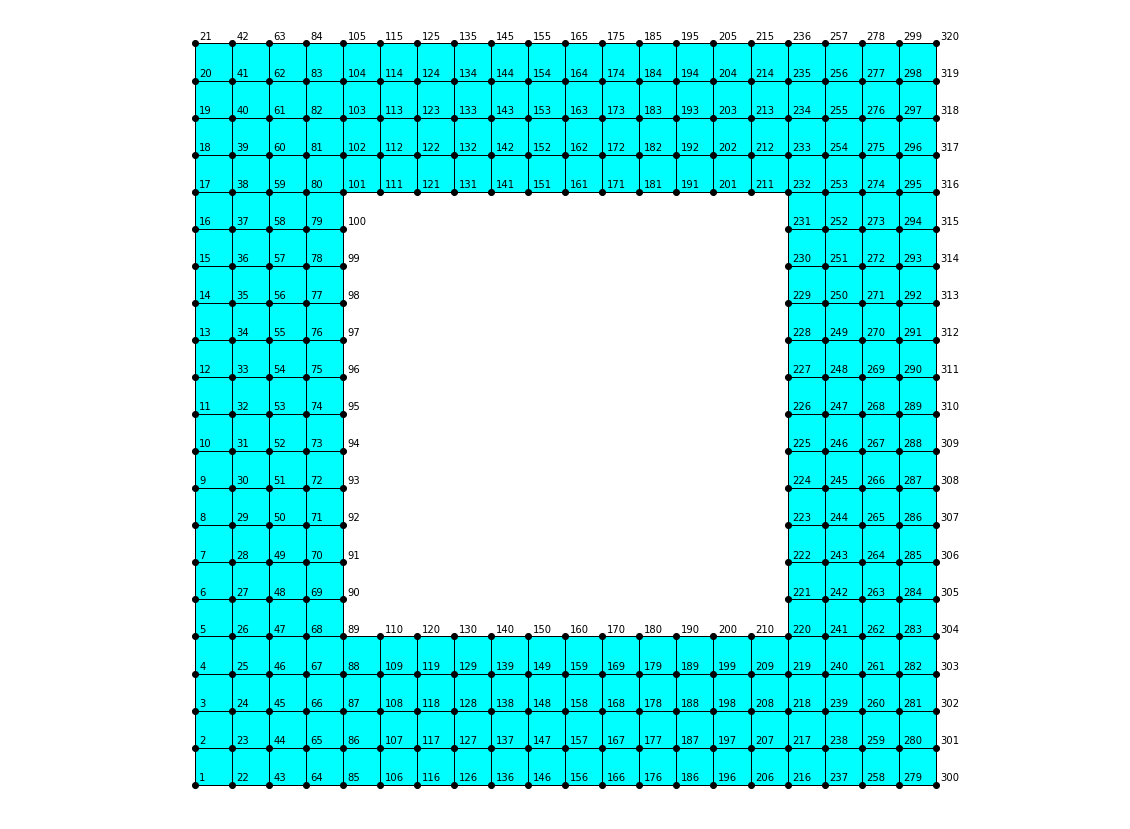

In [29]:
plt.figure(1,figsize=(20.0,15.0))
for k in range(0,nel):
    plt.fill(XX[k,0:4],YY[k,0:4],facecolor=(0.0,1.0,1.0),edgecolor='black')
for k in range(0,npt):
    plt.plot(XY[k,0],XY[k,1],marker='o',color='black')
    plt.text(XY[k,0]+dx/8,XY[k,1]+dy/8,str(k+1),fontsize=10)
plt.axis('equal')
plt.axis('off')
plt.show()

In [30]:
UTaverage = np.zeros((Nrow,1))
for t in range(0,Nrow):
    UTaverage[t] = sum(UT[:,t])/npt

In [31]:
nnodes = int(input("Enter the total number of nodes: "))
lnodes = np.array([],int)
for i in range(nnodes):
    lnodes = np.append(lnodes,int(input("Enter the number label of the node: ")))

Enter the total number of nodes: 1
Enter the number label of the node: 5


In [32]:
MMC = np.zeros((Nrow,nnodes+1))
for t in range(0,Nrow):
    MMC[t,0] = UTaverage[t]
for i in range(0,nnodes):
    for t in range(0,Nrow):
        MMC[t,i+1] = UT[lnodes[i]-1,t]

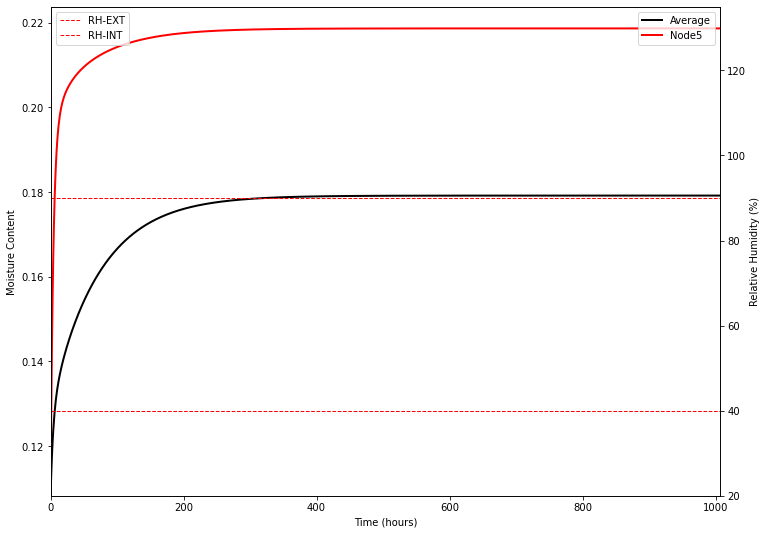

In [33]:
fig,ax1 = plt.subplots(figsize=(12.0,9.0))
ax2 = ax1.twinx()
ColorIndex=ColorMatrix(nnodes+1)            
LabelIndex=LabelList(lnodes)
for i in range(0,nnodes+1):
    ax1.plot(TimeH,MMC[:,i],color=ColorIndex[i,:],linestyle='solid',linewidth=2,label=LabelIndex[i])
ax2.plot(TimeH,RHum_ext,color='r',linestyle='dashed',linewidth=1,label='RH-EXT')
ax2.plot(TimeH,RHum_int,color='r',linestyle='dashed',linewidth=1,label='RH-INT')
ax1.set_xlabel('Time (hours)')
ax1.set_xlim(Timemin,Timemax)
ax1.set_ylabel('Moisture Content',color='k')
ax1.set_ylim(UTmin,UTmax)
ax2.set_ylabel('Relative Humidity (%)',color='k')
ax2.set_ylim(0.5*RHmin,1.5*RHmax)
# ax2.set_ylabel('Temperature (°C)',color='k')
# ax2.set_ylim(0.5*TCmin,1.5*TCmax)
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()

# Writing Output Data to a File

In [34]:
listallnodes = np.arange(1,npt+1,1)
LabelAllIndex = LabelList(listallnodes)
MMCAll = np.zeros((Nrow,npt+1))
for t in range(0,Nrow):
    MMCAll[t,0] = UTaverage[t]
for i in range(0,npt):
    for t in range(0,Nrow):
        MMCAll[t,i+1] = UT[listallnodes[i]-1,t]

In [35]:
OUT1 = 'Time'
OUT2 = LabelAllIndex
OUT3 = np.append(OUT1,OUT2)
OUT4 = TimeH
OUT5 = MMCAll
OUT6 = np.column_stack((OUT4,OUT5))
result1 = pd.DataFrame([OUT3])
result2 = pd.DataFrame(OUT6)
result = result1.append(result2)
writer = pd.ExcelWriter('Hollow_Implicit_Results.xlsx',engine='xlsxwriter')
result.to_excel(writer,sheet_name='Moisture_Content_Matrix',index=False,header=False)
writer.save()